In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from keras import layers

In [2]:
# to open the files in order
def get_files(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [3]:
# defining the size of the image
SIZE = 160
color_img = []
path = 'D:\landscape Images/color'
files = os.listdir(path)
files =  get_files(files)
for i in tqdm(files):    
    if i == '2000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        # conver image to numby array
        color_img.append(img_to_array(img))

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 475.62it/s]


In [4]:
gray_img = []
path = 'D:\landscape Images/gray'
files = os.listdir(path)
files =  get_files(files)
for i in tqdm(files):
    if i == '3000.jpg':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1902.55it/s]


In [5]:
def plot_images(color,grayscale):
    plt.figure(figsize=(10,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.show()

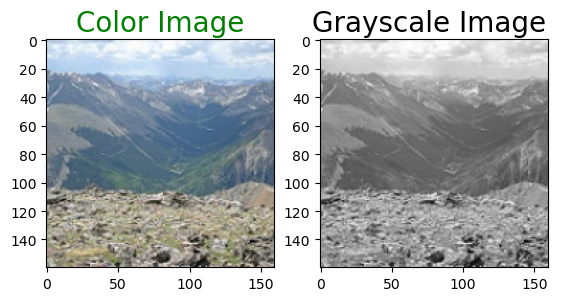

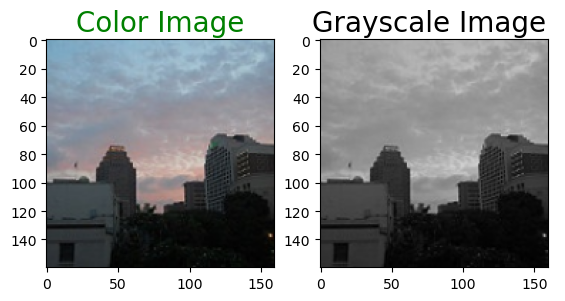

In [6]:
for i in range(1500,1502):
     plot_images(color_img[i],gray_img[i])

In [7]:
#Train Dta

train_gray_image = gray_img[:1800]
train_color_image = color_img[:1800]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


#Test Data

test_gray_image = gray_img[1800:]
test_color_image = color_img[1800:]
# reshaping
test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (1800, 160, 160, 3)
Test color image shape (200, 160, 160, 3)


In [8]:
def down_sample(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [9]:
def up_sample(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [10]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down_sample(128,(3,3),False)(inputs)
    d2 = down_sample(128,(3,3),False)(d1)
    d3 = down_sample(256,(3,3),True)(d2)
    d4 = down_sample(512,(3,3),True)(d3)
    d5 = down_sample(512,(3,3),True)(d4)
    
    #upsampling
    u1 = up_sample(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up_sample(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up_sample(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up_sample(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up_sample(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [11]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [12]:
batchSize=50
Epochs=100
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',metrics = ['acc'])

model.fit(train_g, train_c, epochs = Epochs,batch_size = batchSize,verbose = 1)

Epoch 1/100
36/36 [==============================] - 121s 3s/step - loss: 0.1603 - acc: 0.3568
Epoch 2/100
36/36 [==============================] - 120s 3s/step - loss: 0.0712 - acc: 0.4144
Epoch 3/100
36/36 [==============================] - 121s 3s/step - loss: 0.0644 - acc: 0.4406
Epoch 4/100
36/36 [==============================] - 121s 3s/step - loss: 0.0607 - acc: 0.4568
Epoch 5/100
36/36 [==============================] - 123s 3s/step - loss: 0.0593 - acc: 0.4611
Epoch 6/100
36/36 [==============================] - 122s 3s/step - loss: 0.0564 - acc: 0.4686
Epoch 7/100
36/36 [==============================] - 123s 3s/step - loss: 0.0545 - acc: 0.4781
Epoch 8/100
36/36 [==============================] - 124s 3s/step - loss: 0.0540 - acc: 0.4755
Epoch 9/100
36/36 [==============================] - 123s 3s/step - loss: 0.0526 - acc: 0.4885
Epoch 10/100
36/36 [==============================] - 124s 3s/step - loss: 0.0520 - acc: 0.4843
Epoch 11/100
36/36 [=============================

In [13]:
model.evaluate(test_gray_image,test_color_image)

7/7 [==============================] - 6s 637ms/step - loss: 0.0502 - acc: 0.4832


[0.0501638799905777, 0.4831812381744385]

1/1 [==============================] - 0s 41ms/step


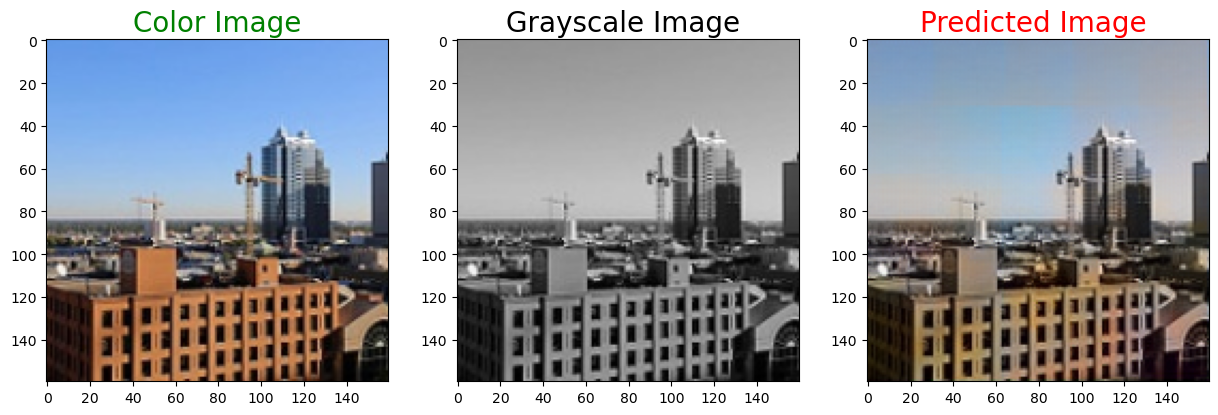

1/1 [==============================] - 0s 46ms/step


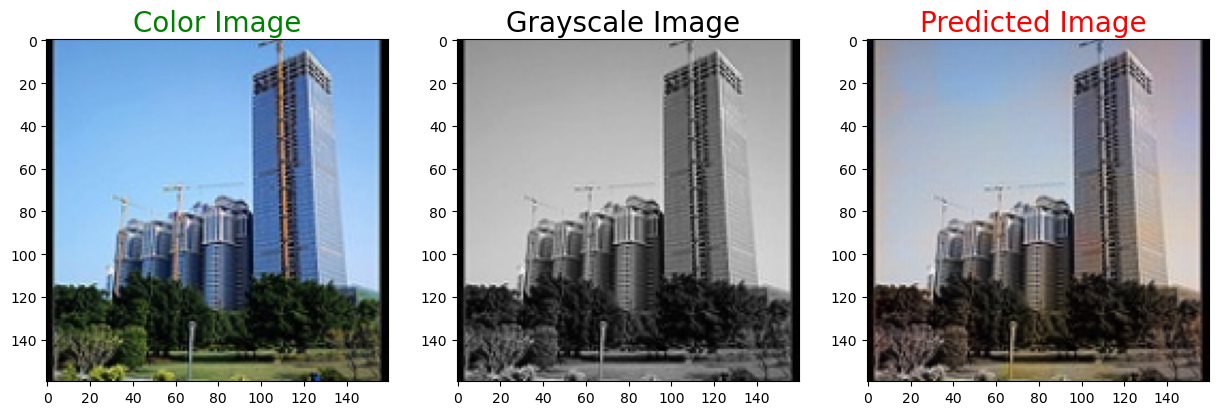

1/1 [==============================] - 0s 60ms/step


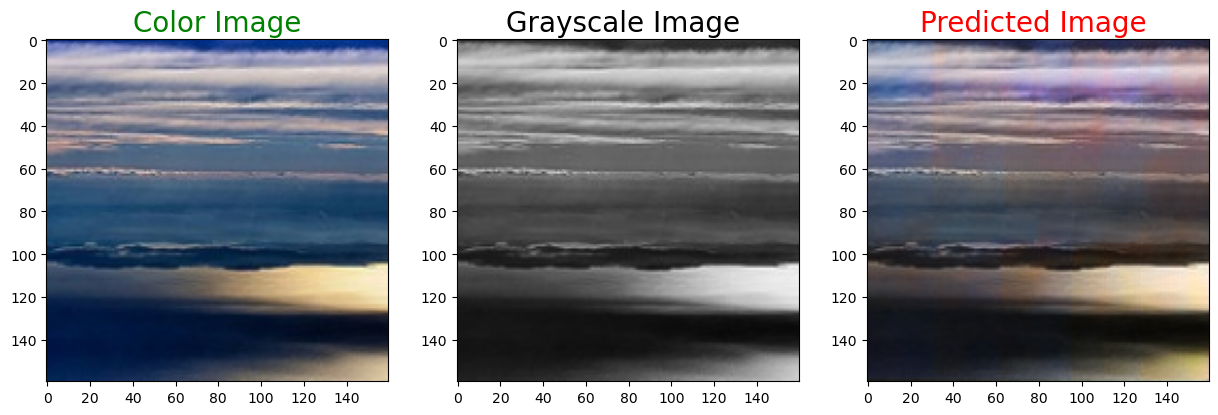

1/1 [==============================] - 0s 58ms/step


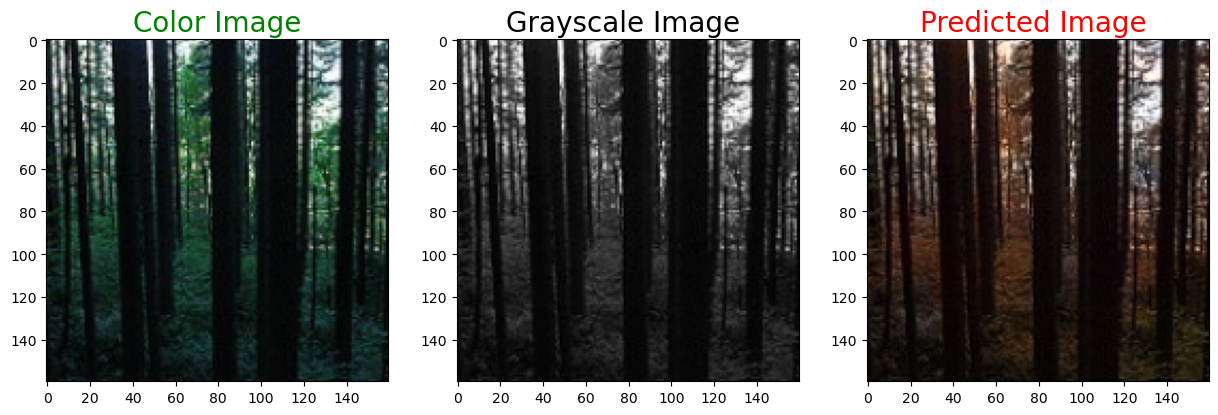

1/1 [==============================] - 0s 58ms/step


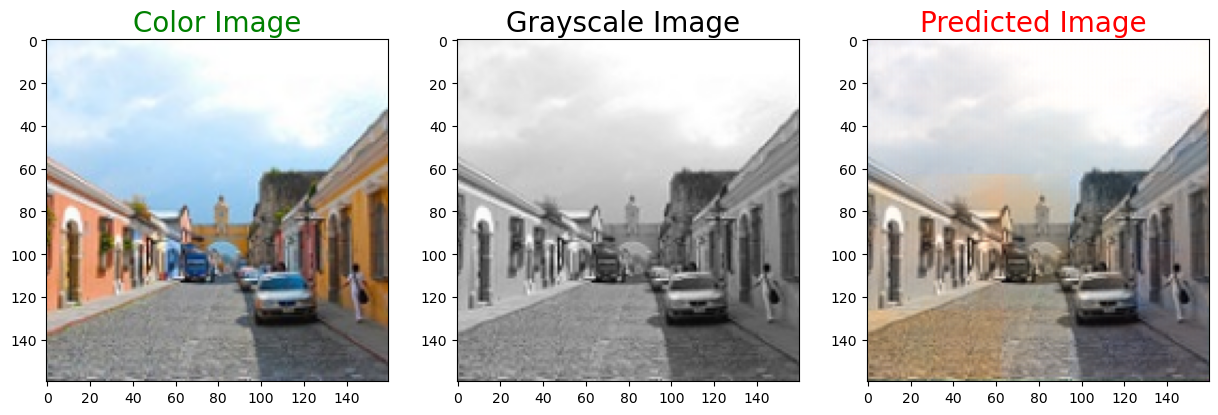

1/1 [==============================] - 0s 48ms/step


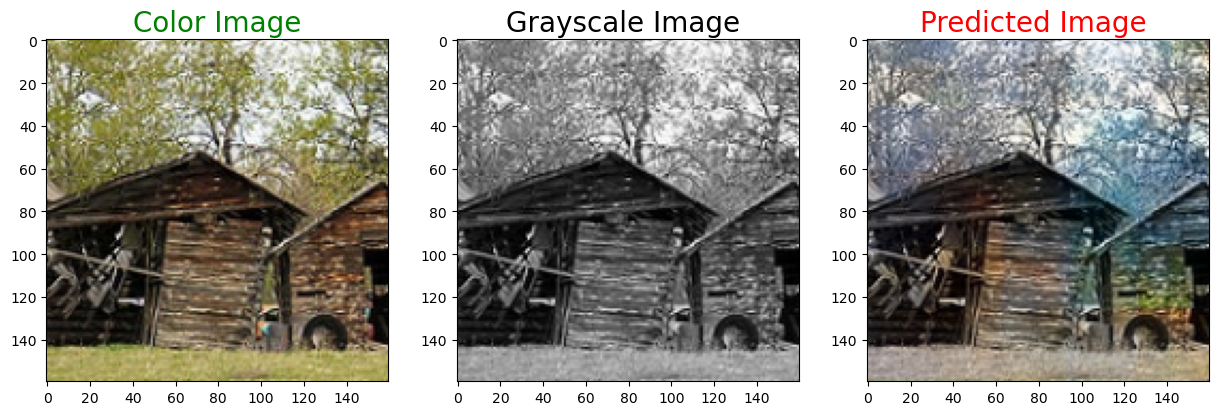

1/1 [==============================] - 0s 47ms/step


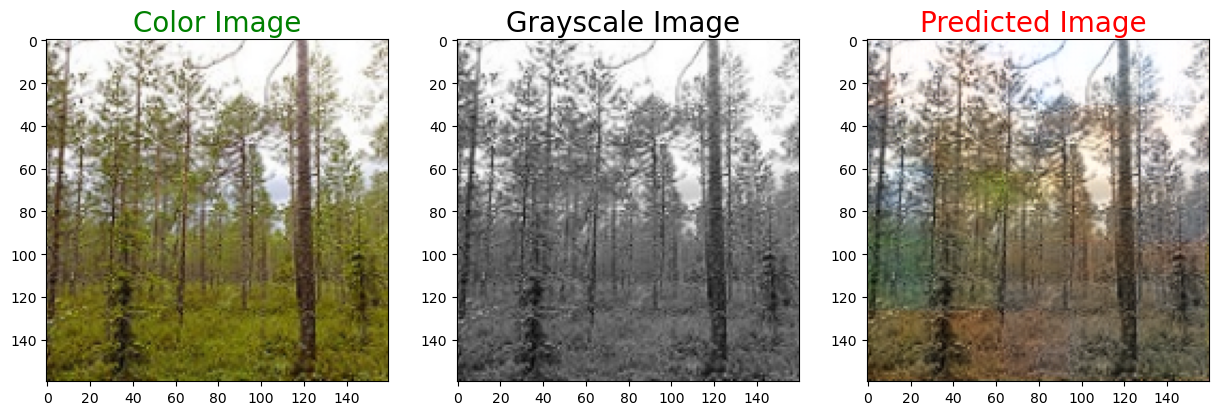

1/1 [==============================] - 0s 42ms/step


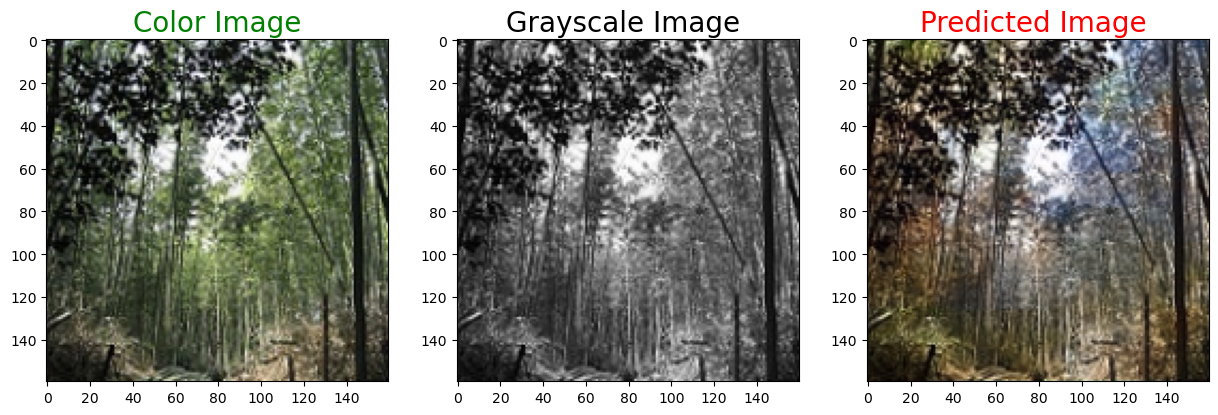

In [29]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(67,75):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)